In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'WCH.DE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,1087,-897,190,-19,432,614,617,1945,0,...,6332,309,0,169,1059,1247,4154,33,0,49.0
1,2014-03-31,1157,-993,164,64,359,699,674,2019,0,...,6589,330,0,290,1326,1158,4462,149,0,49.0
2,2014-06-30,1242,-1008,234,29,348,742,690,2076,0,...,6616,318,0,318,1227,1140,4575,110,0,49.0
3,2014-09-30,1232,-996,237,119,448,750,744,2303,0,...,7046,365,0,293,1295,1300,4957,194,0,49.0
4,2014-12-31,1195,-986,209,-17,326,684,734,2093,0,...,6947,375,0,263,1165,1318,5025,33,0,49.0


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,49.7,1826,-1467,359,229,895,916,1656,...,213,9401,886,0,461,1927,1086,4371,213,-185
37,2023-03-31,2023-04-21,49.7,1744,-1412,332,147,1324,988,1645,...,207,9594,838,0,452,1931,1180,4476,190,-141
38,2023-06-30,2023-07-21,49.7,1753,-1430,323,119,812,924,1527,...,307,8712,774,0,437,1657,1089,4262,162,-130
39,2023-09-30,2023-10-21,49.7,1523,-1325,198,34,935,879,1455,...,308,8812,754,0,443,1692,1095,4071,275,-147
40,2023-12-31,2024-02-11,49.7,1382,-1152,230,27,1013,788,1449,...,293,8854,879,0,418,1763,1088,4275,309,-221


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,49.7,1826,-1467,359,229,895,916,1656,...,9401,886,0,461,1927,1086,4371,213,-185,0.980663
37,2023-03-31,2023-04-21,49.7,1744,-1412,332,147,1324,988,1645,...,9594,838,0,452,1931,1180,4476,190,-141,0.932003
38,2023-06-30,2023-07-21,49.7,1753,-1430,323,119,812,924,1527,...,8712,774,0,437,1657,1089,4262,162,-130,0.918362
39,2023-09-30,2023-10-21,49.7,1523,-1325,198,34,935,879,1455,...,8812,754,0,443,1692,1095,4071,275,-147,0.918837
40,2023-12-31,2024-02-11,49.7,1382,-1152,230,27,1013,788,1449,...,8854,879,0,418,1763,1088,4275,309,-221,0.929674


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,49.7,1826,-1467,359,229,895,916,1656,...,9401,886,0,461,1927,1086,4371,213,-185,0.980663
37,2023-03-31,2023-04-21,49.7,1744,-1412,332,147,1324,988,1645,...,9594,838,0,452,1931,1180,4476,190,-141,0.932003
38,2023-06-30,2023-07-21,49.7,1753,-1430,323,119,812,924,1527,...,8712,774,0,437,1657,1089,4262,162,-130,0.918362
39,2023-09-30,2023-10-21,49.7,1523,-1325,198,34,935,879,1455,...,8812,754,0,443,1692,1095,4071,275,-147,0.918837
40,2023-12-31,2024-02-11,49.7,1382,-1152,230,27,1013,788,1449,...,8854,879,0,418,1763,1088,4275,309,-221,0.929674


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,70.996094,2013-12-31,1087.0,-1.55102,44.44898,49.0,132.0,2.693878,432.0,...,0.343967,0.656033,7.081433,11.61165,10.064815,5.815235,0.174793,-0.017479,-0.012003,-0.034894
1,2014-02-24,74.172173,2013-12-31,1087.0,-1.55102,44.44898,49.0,132.0,2.693878,432.0,...,0.343967,0.656033,7.081433,11.61165,10.064815,5.815235,0.174793,-0.017479,-0.012003,-0.034894
2,2014-03-03,76.105148,2013-12-31,1087.0,-1.55102,44.44898,49.0,132.0,2.693878,432.0,...,0.343967,0.656033,7.081433,11.61165,10.064815,5.815235,0.174793,-0.017479,-0.012003,-0.034894
3,2014-03-10,69.957596,2013-12-31,1087.0,-1.55102,44.44898,49.0,132.0,2.693878,432.0,...,0.343967,0.656033,7.081433,11.61165,10.064815,5.815235,0.174793,-0.017479,-0.012003,-0.034894
4,2014-03-17,66.917938,2013-12-31,1087.0,-1.55102,44.44898,49.0,132.0,2.693878,432.0,...,0.343967,0.656033,7.081433,11.61165,10.064815,5.815235,0.174793,-0.017479,-0.012003,-0.034894


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,70.996094,2013-12-31,1087.0,-1.55102,44.44898,49.0,132.0,2.693878,432.0,...,5.815235,0.174793,-0.017479,-0.012003,-0.034894,-45.773797,1.597249,0.800094,1.656120,26.354611
1,2014-02-24,74.172173,2013-12-31,1087.0,-1.55102,44.44898,49.0,132.0,2.693878,432.0,...,5.815235,0.174793,-0.017479,-0.012003,-0.034894,-47.821532,1.668704,0.835887,1.691913,27.533610
2,2014-03-03,76.105148,2013-12-31,1087.0,-1.55102,44.44898,49.0,132.0,2.693878,432.0,...,5.815235,0.174793,-0.017479,-0.012003,-0.034894,-49.067793,1.712191,0.857671,1.713696,28.251154
3,2014-03-10,69.957596,2013-12-31,1087.0,-1.55102,44.44898,49.0,132.0,2.693878,432.0,...,5.815235,0.174793,-0.017479,-0.012003,-0.034894,-45.104239,1.573885,0.788391,1.644416,25.969108
4,2014-03-17,66.917938,2013-12-31,1087.0,-1.55102,44.44898,49.0,132.0,2.693878,432.0,...,5.815235,0.174793,-0.017479,-0.012003,-0.034894,-43.144460,1.505500,0.754135,1.610161,24.840750


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

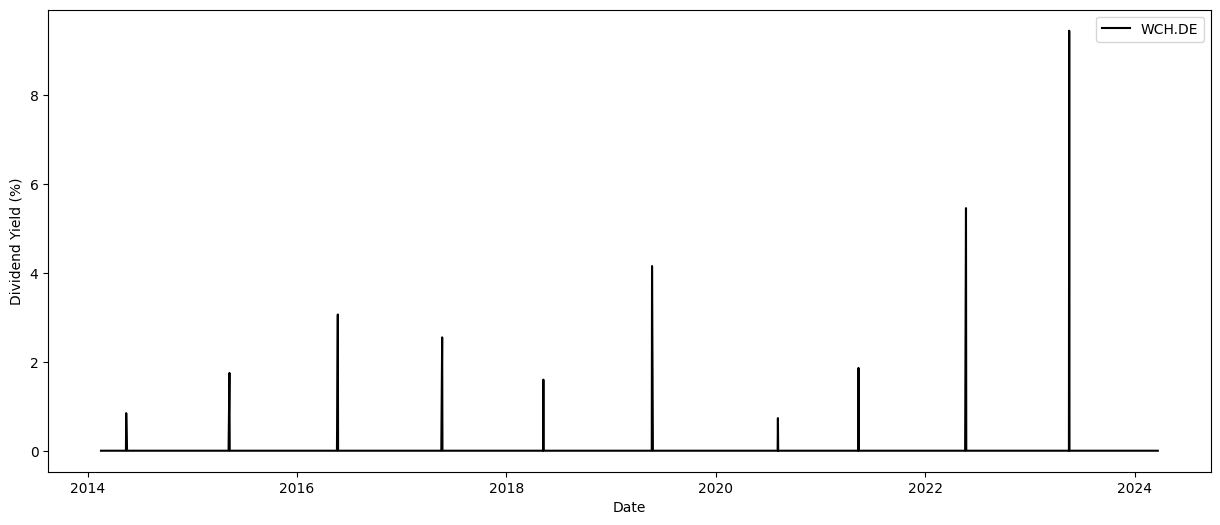

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.170399
share_price      1.000000
Name: share_price, dtype: float64


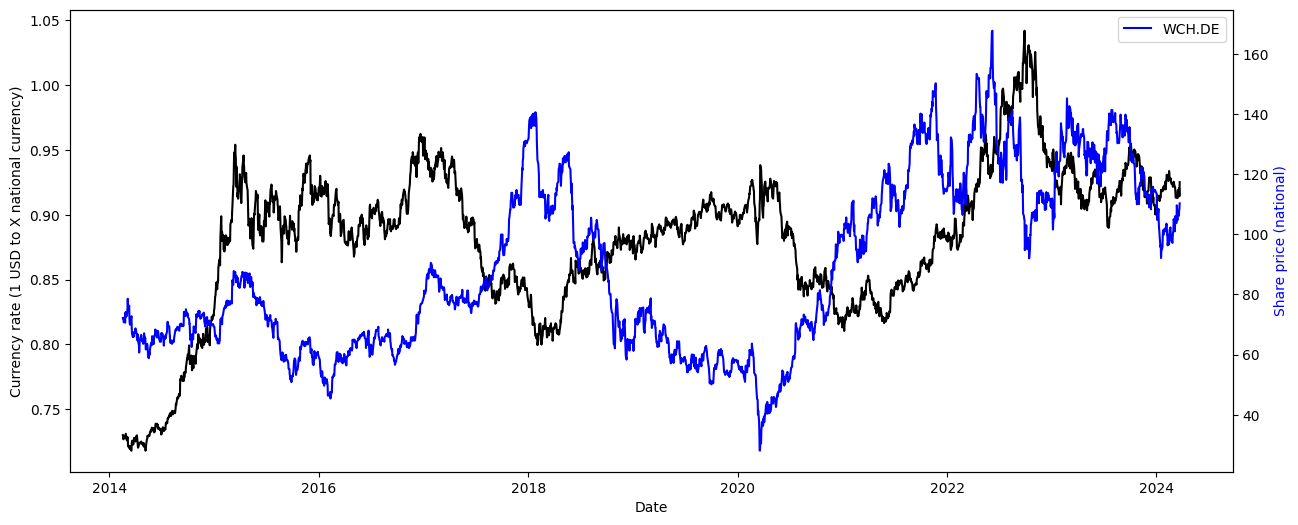

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

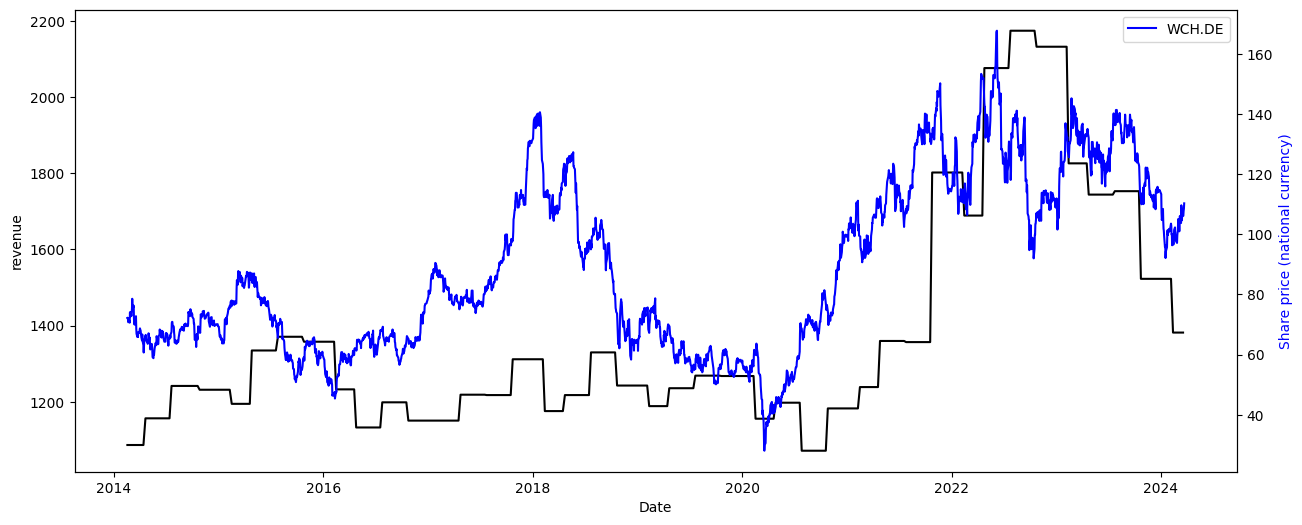

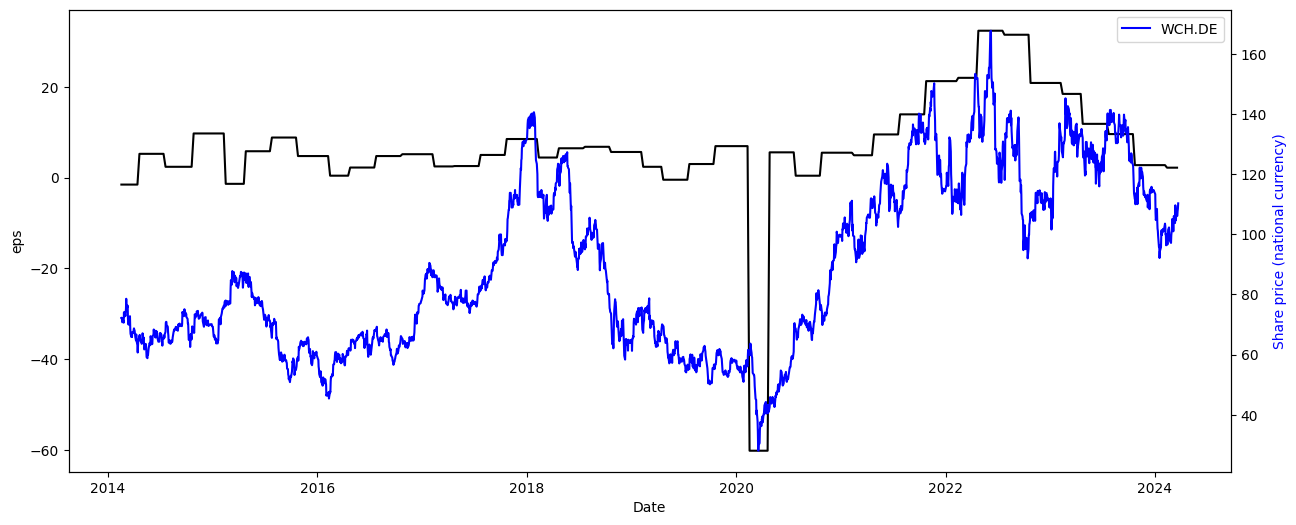

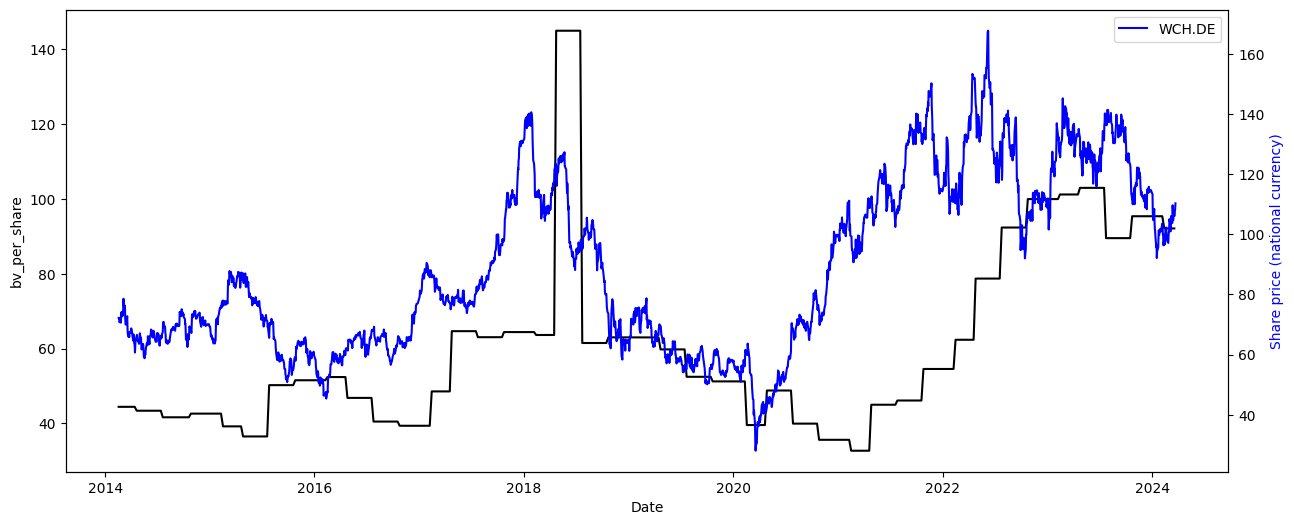

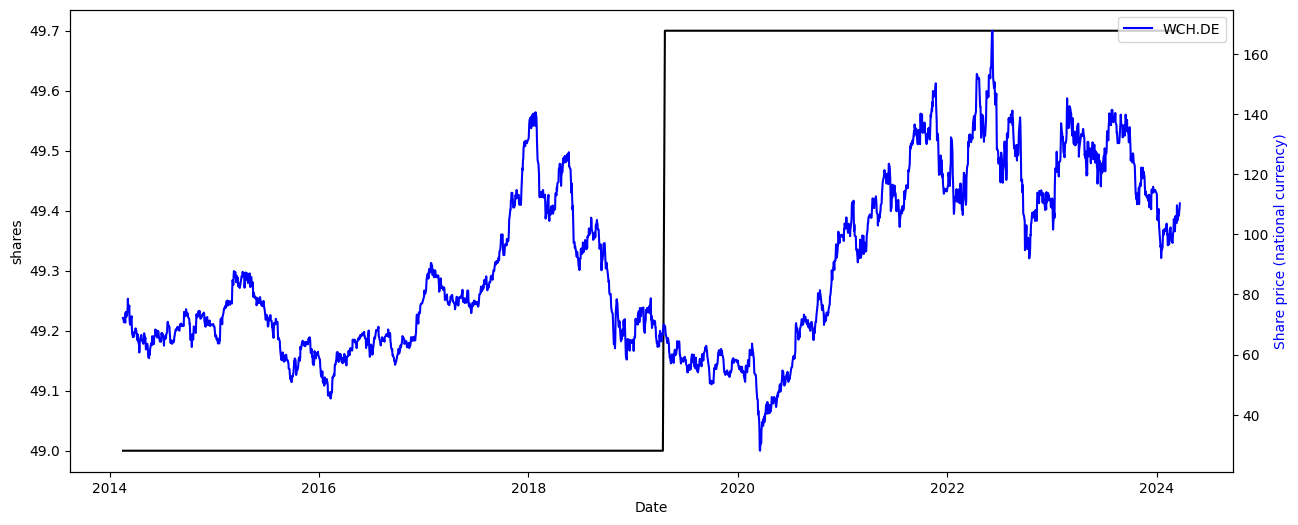

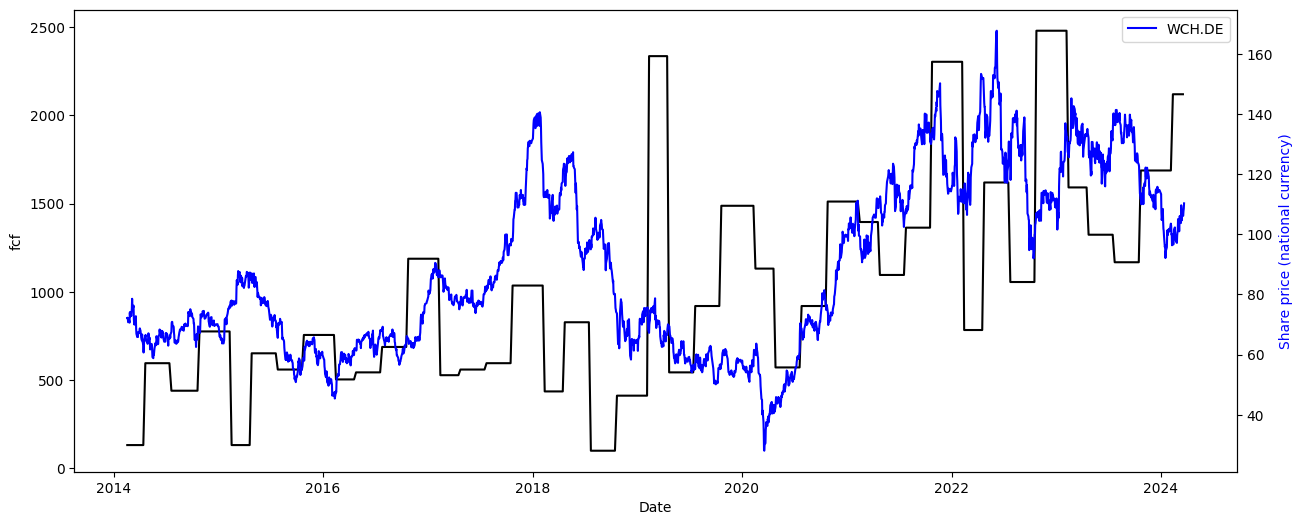

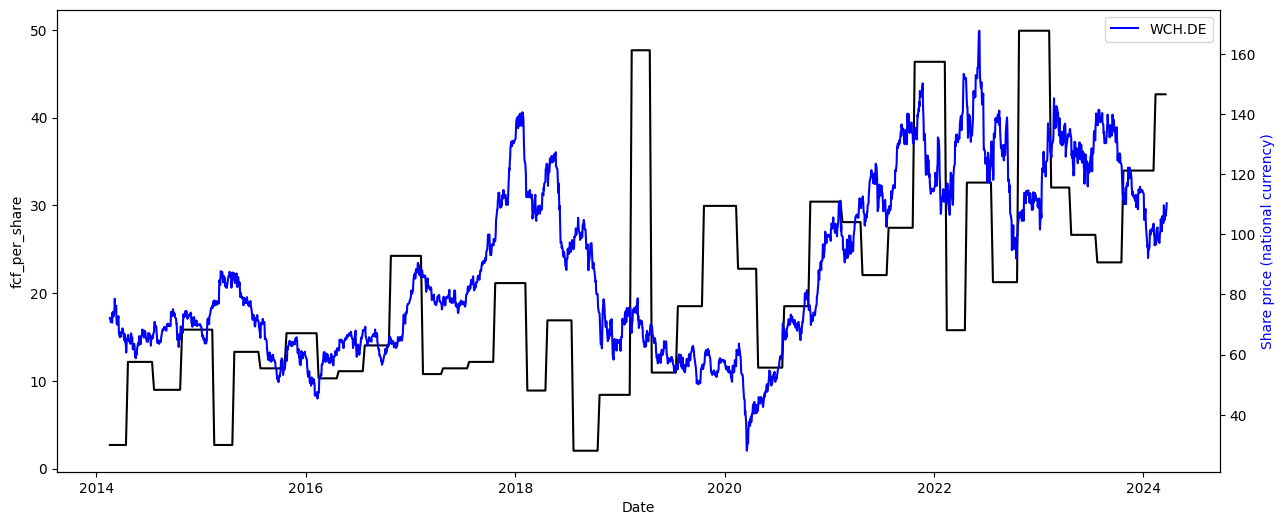

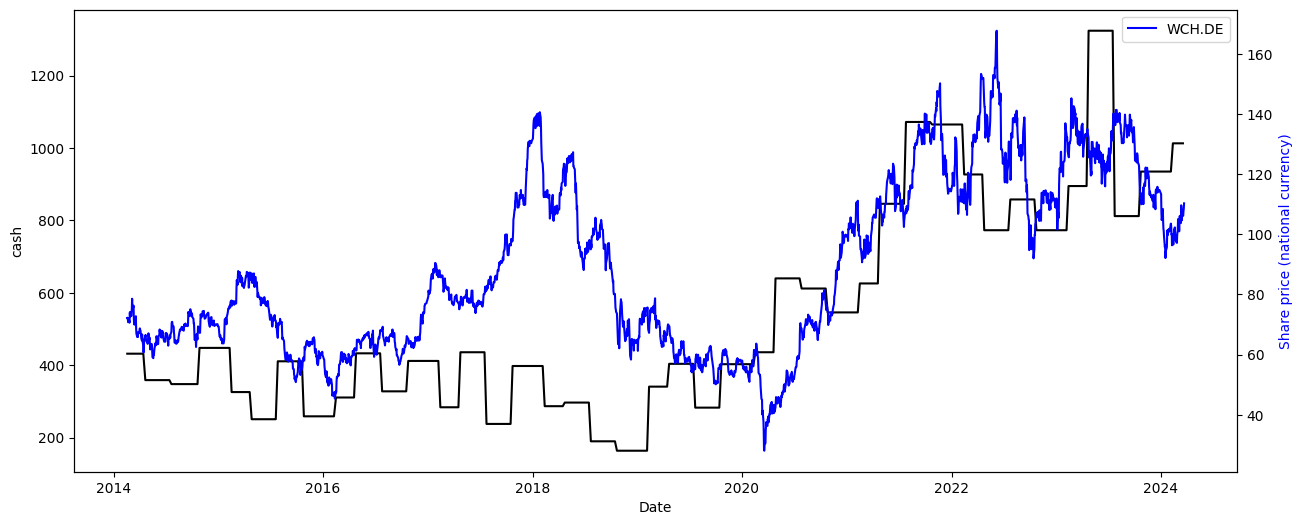

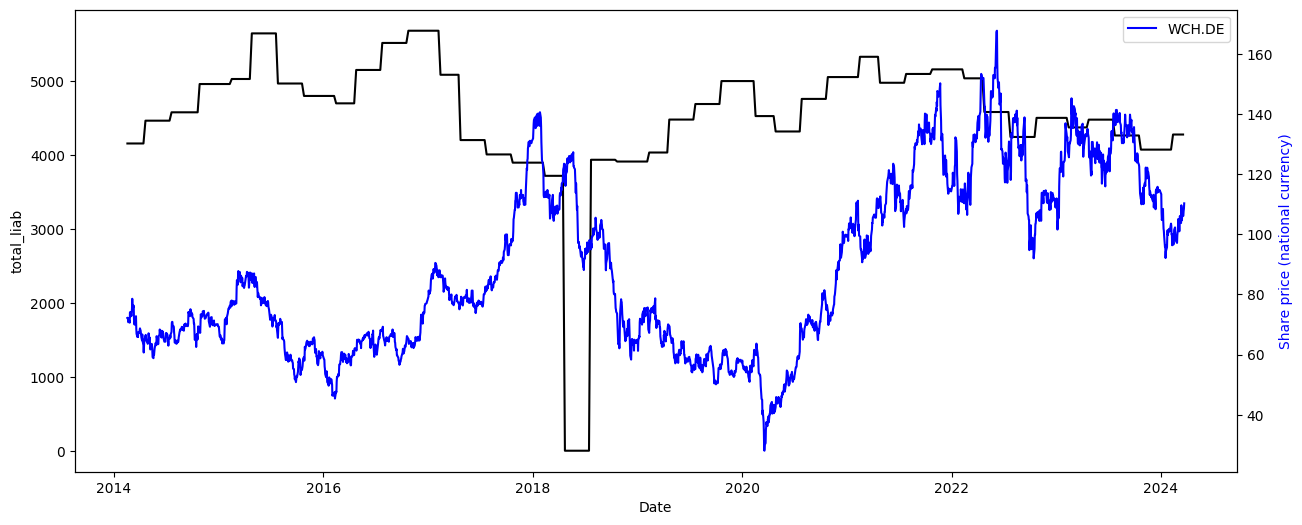

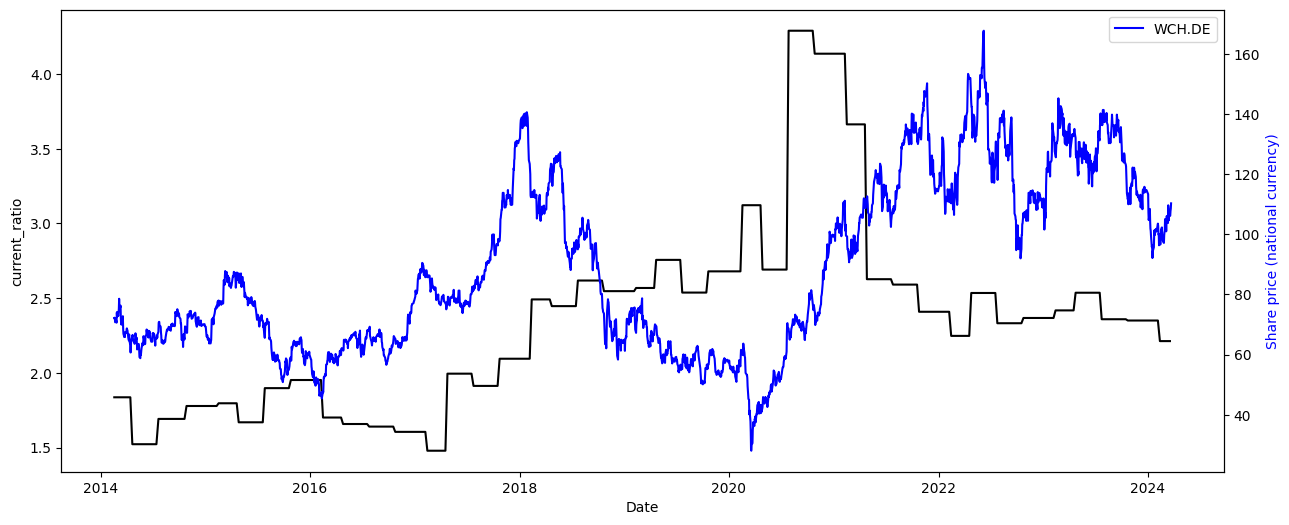

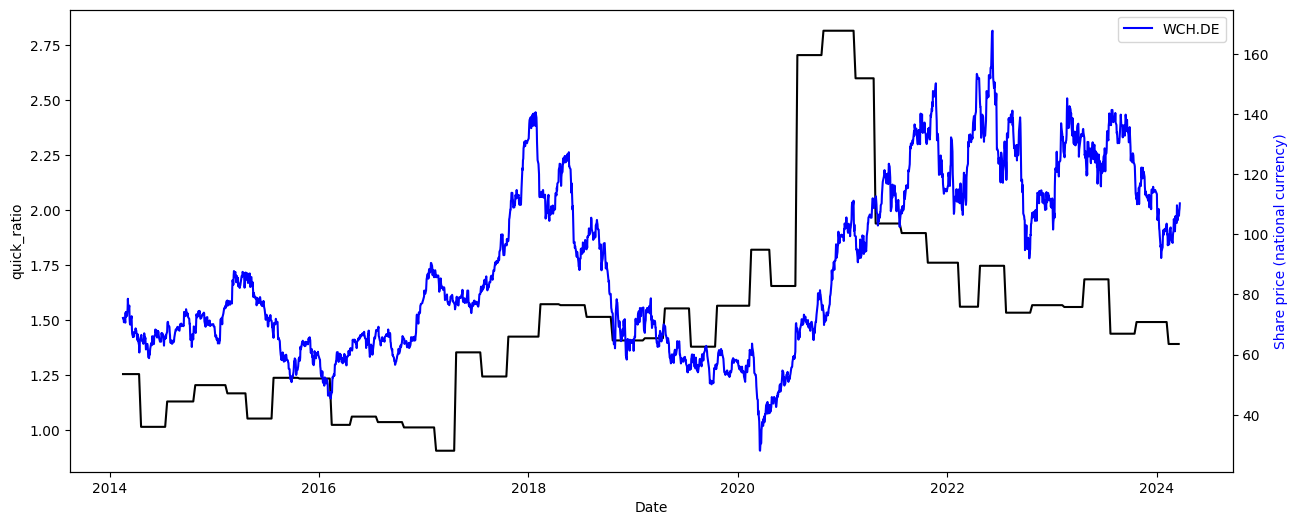

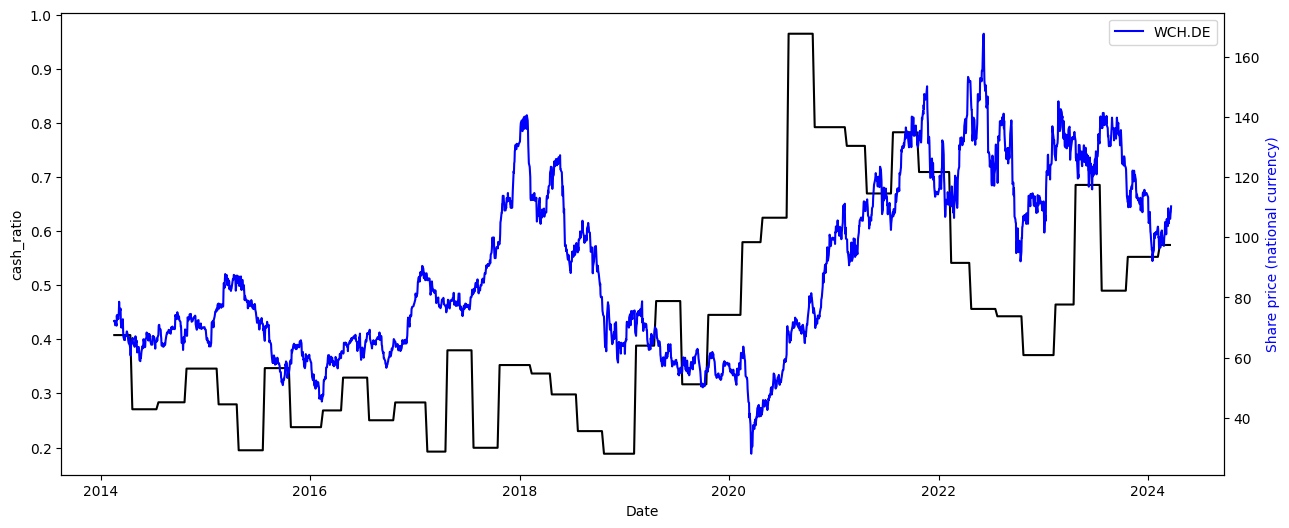

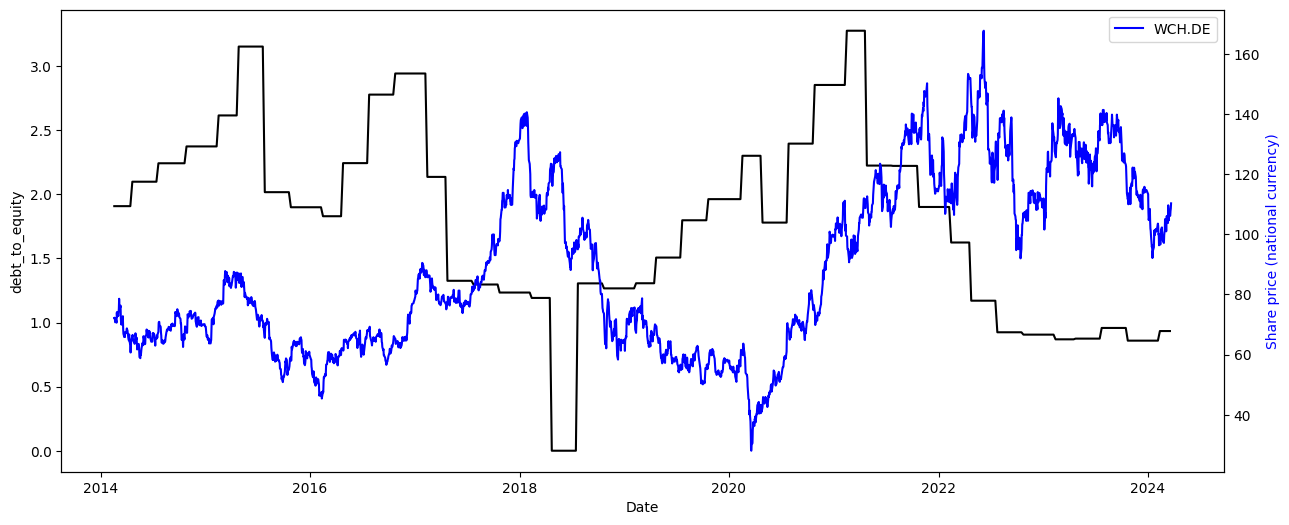

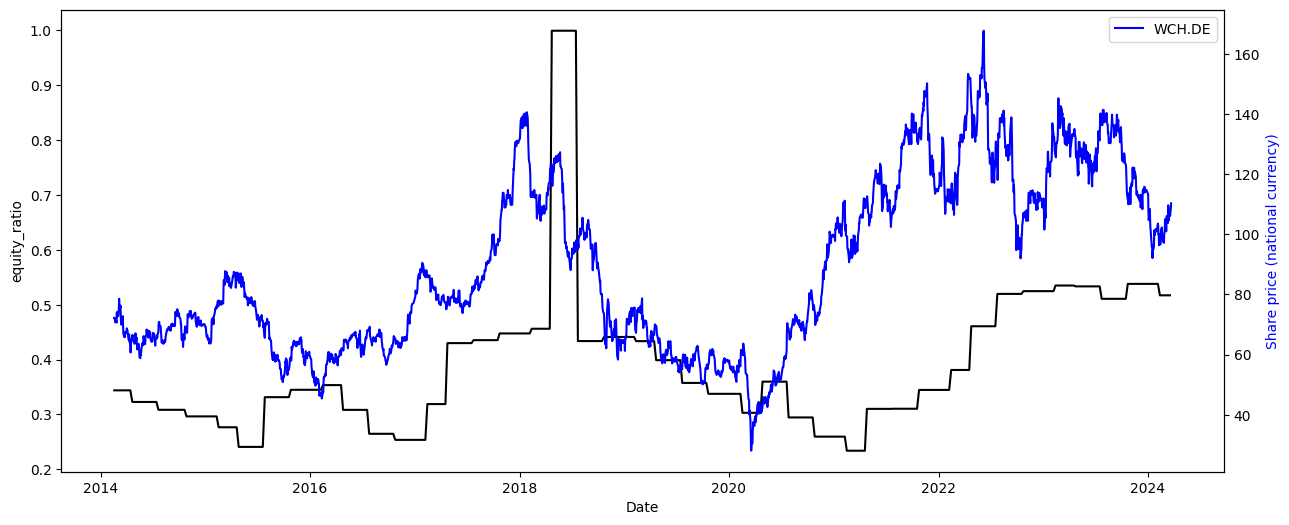

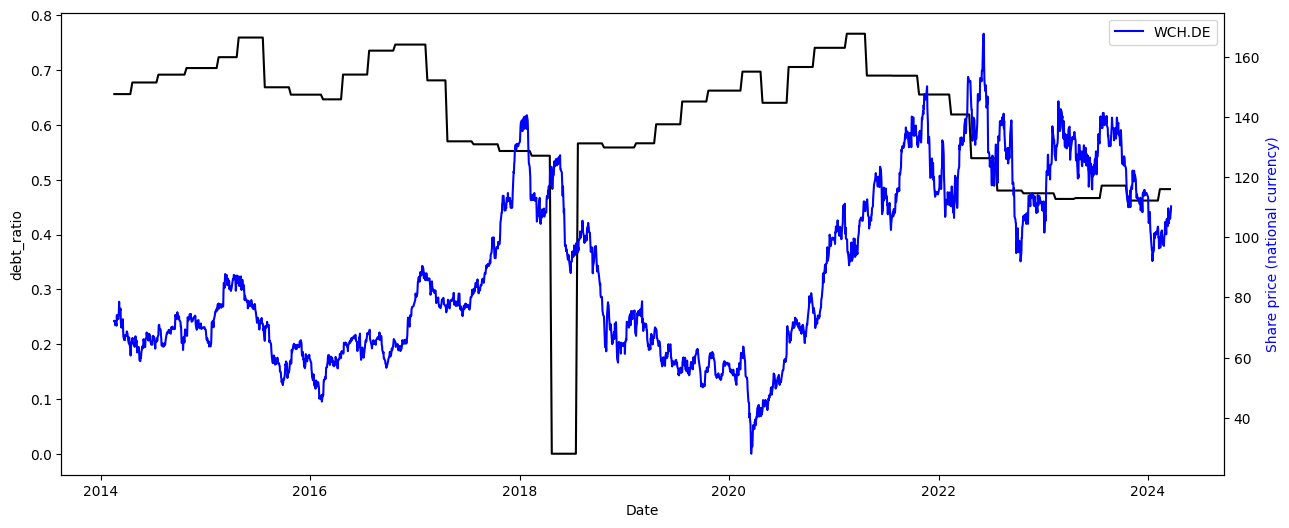

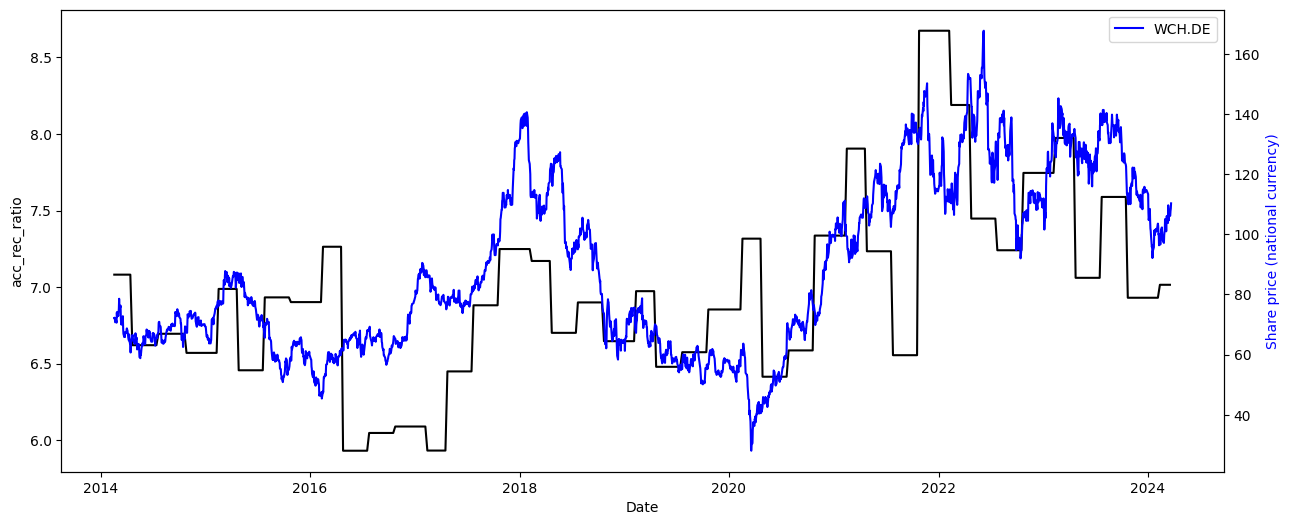

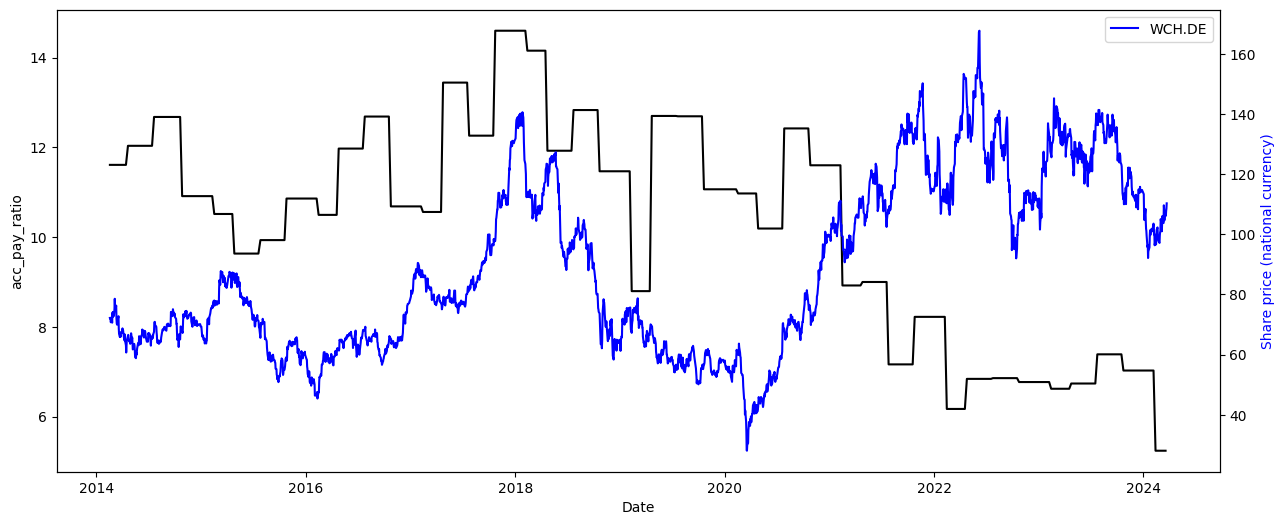

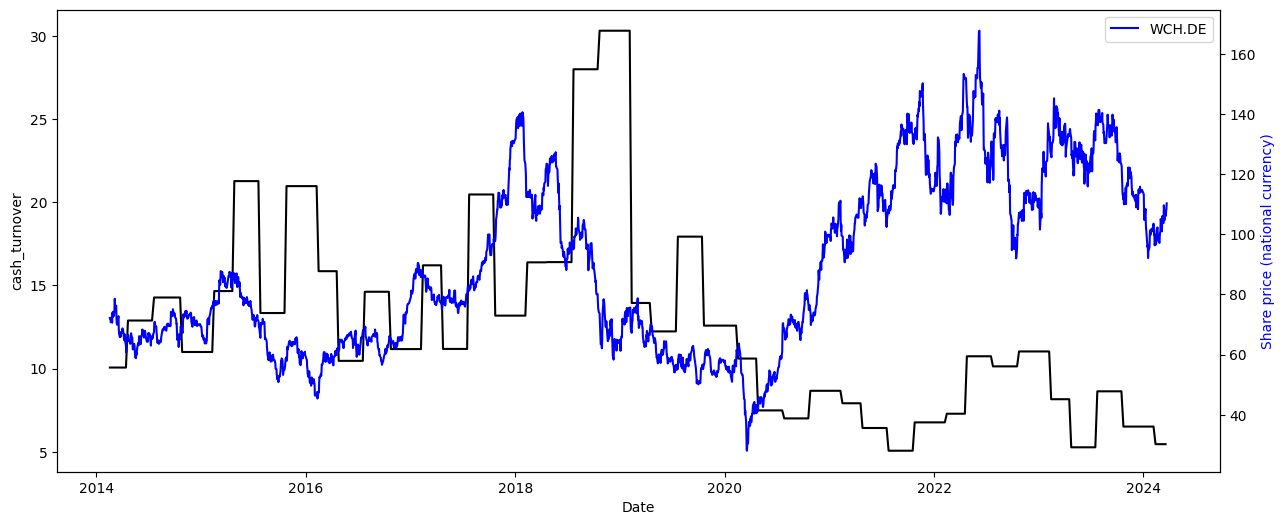

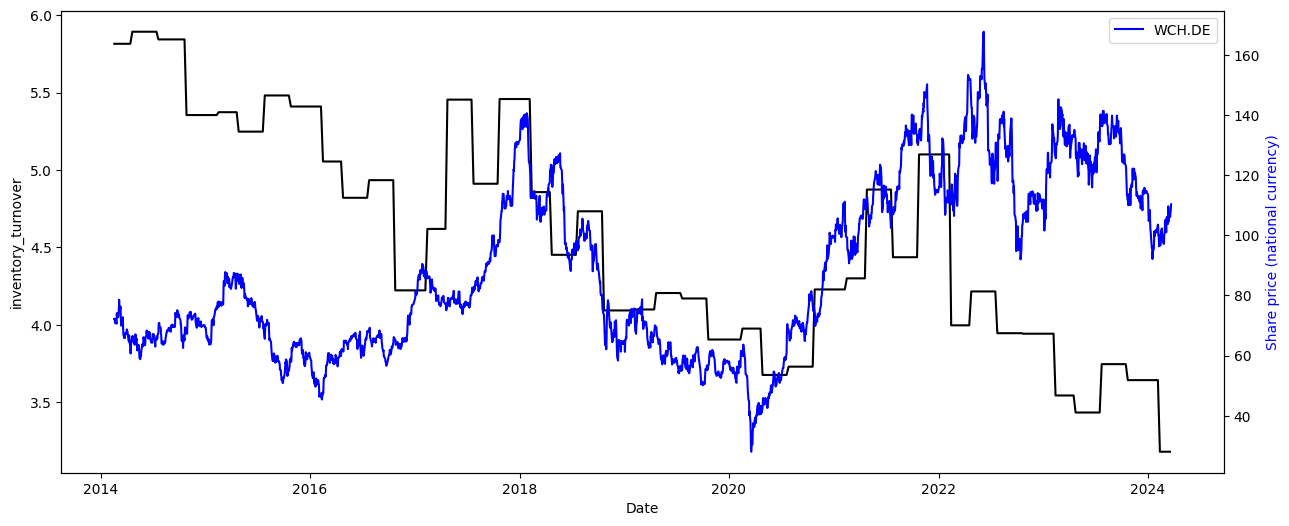

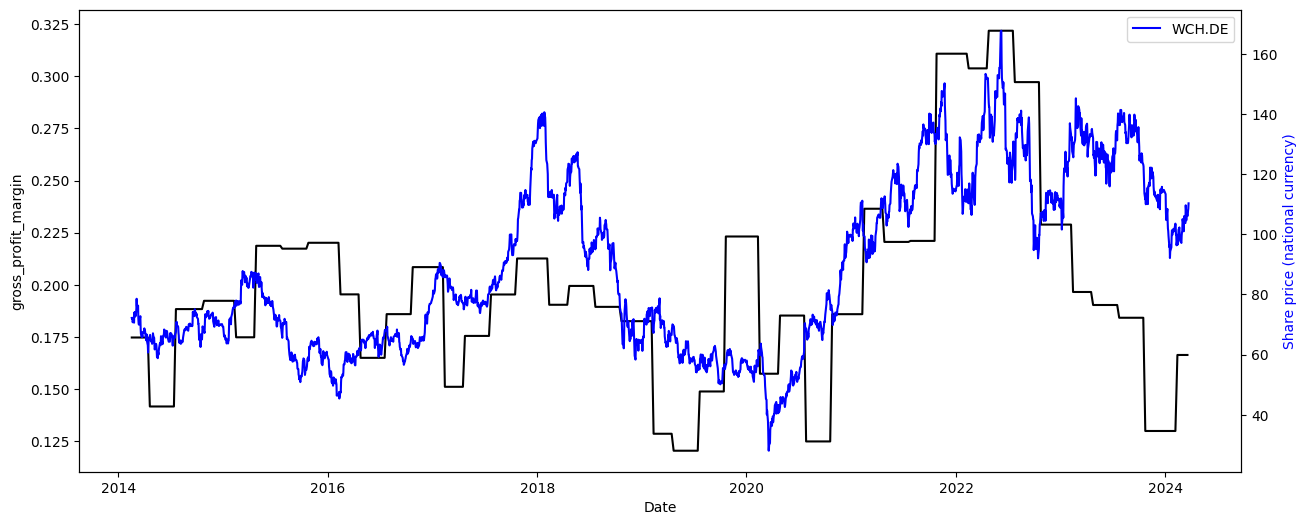

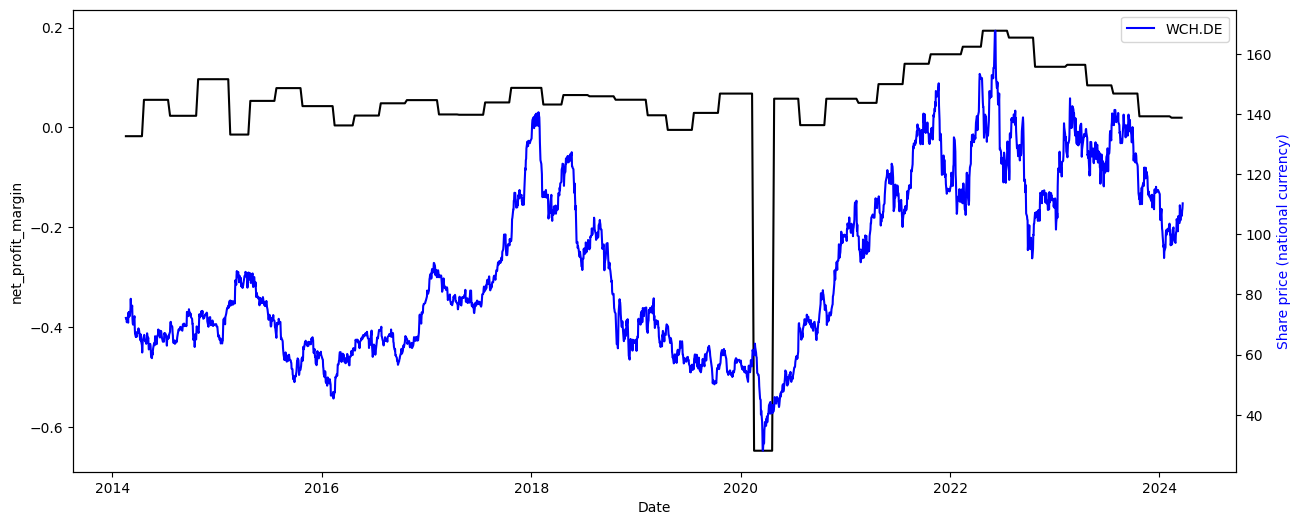

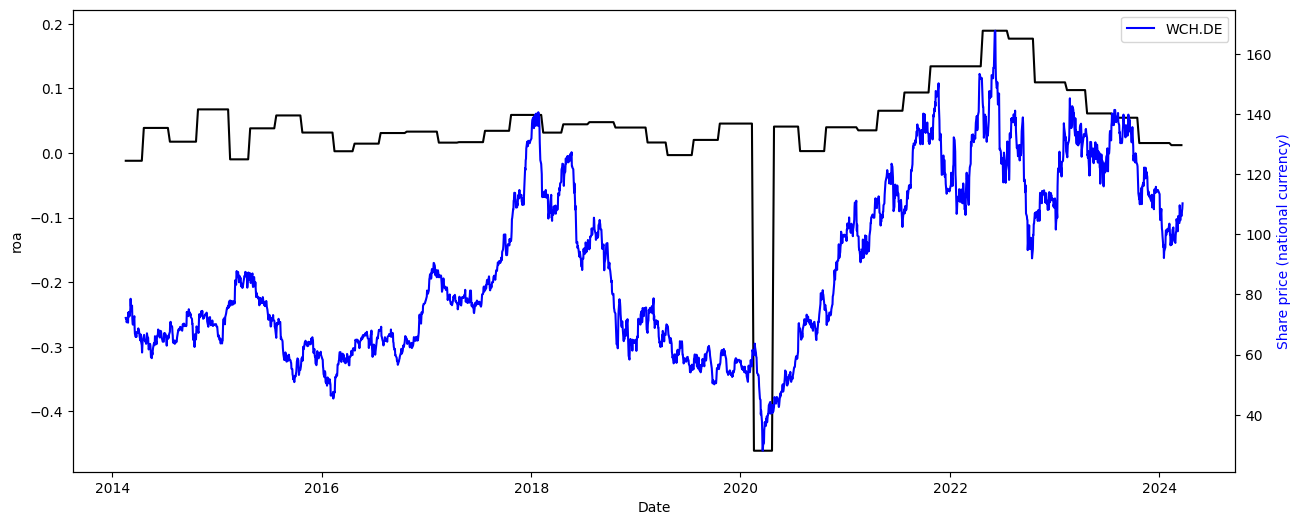

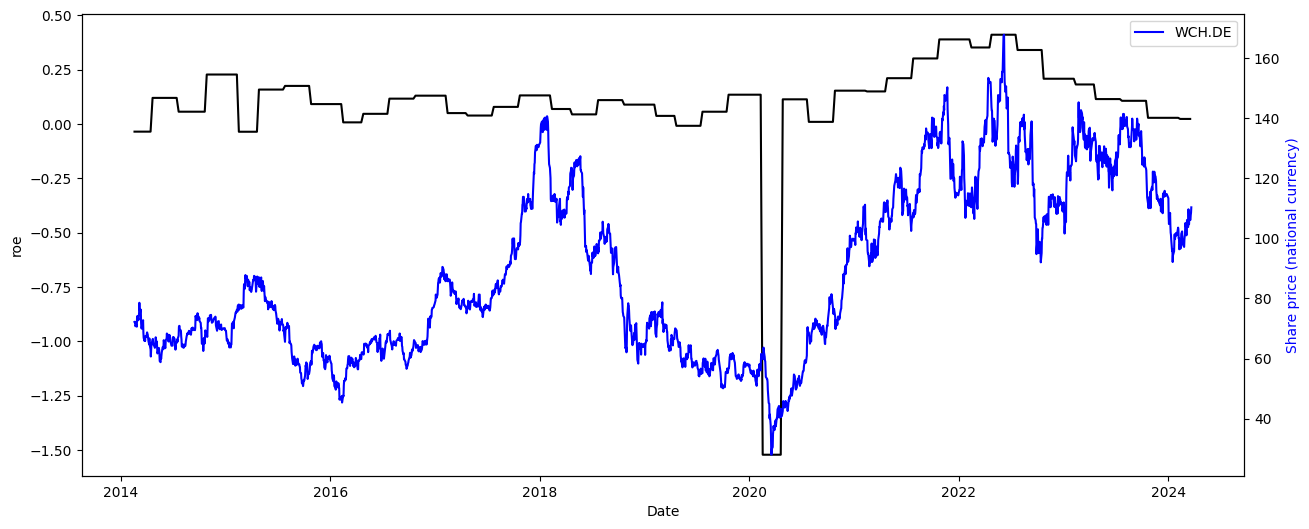

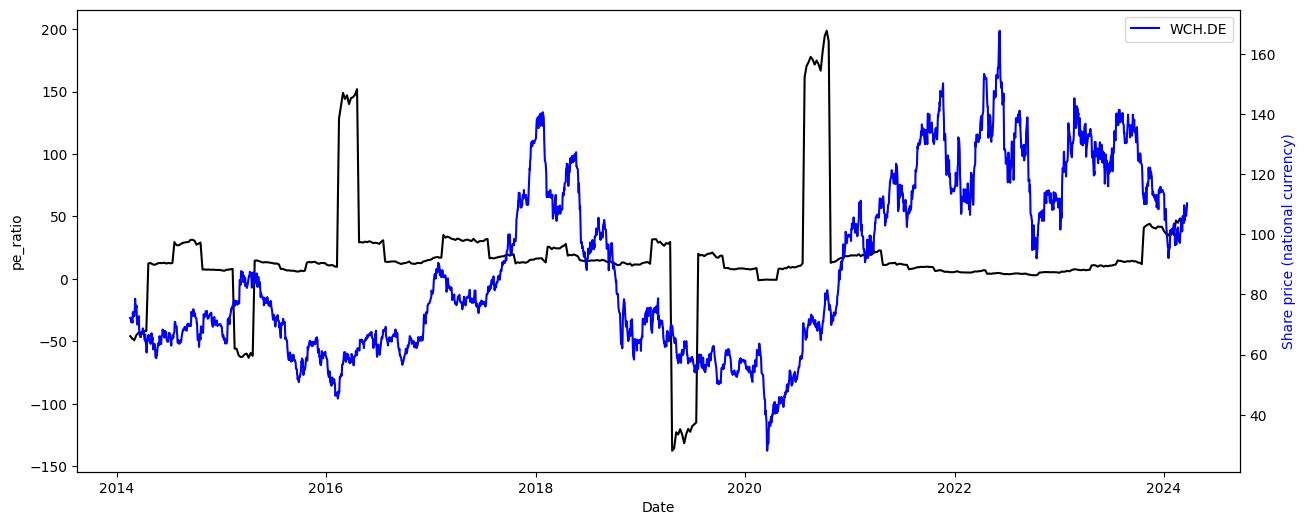

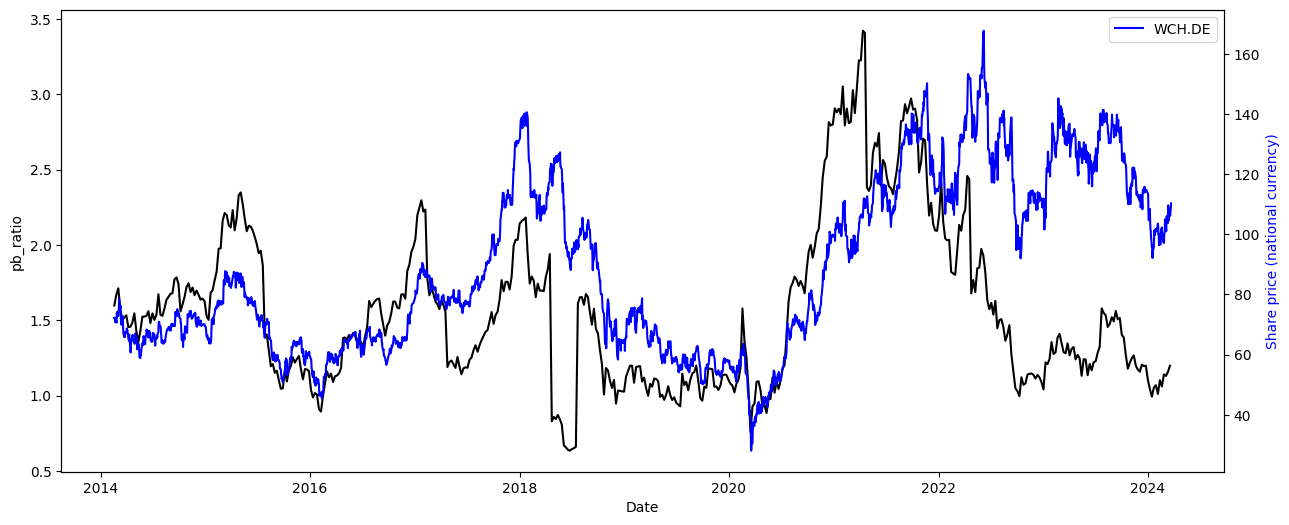

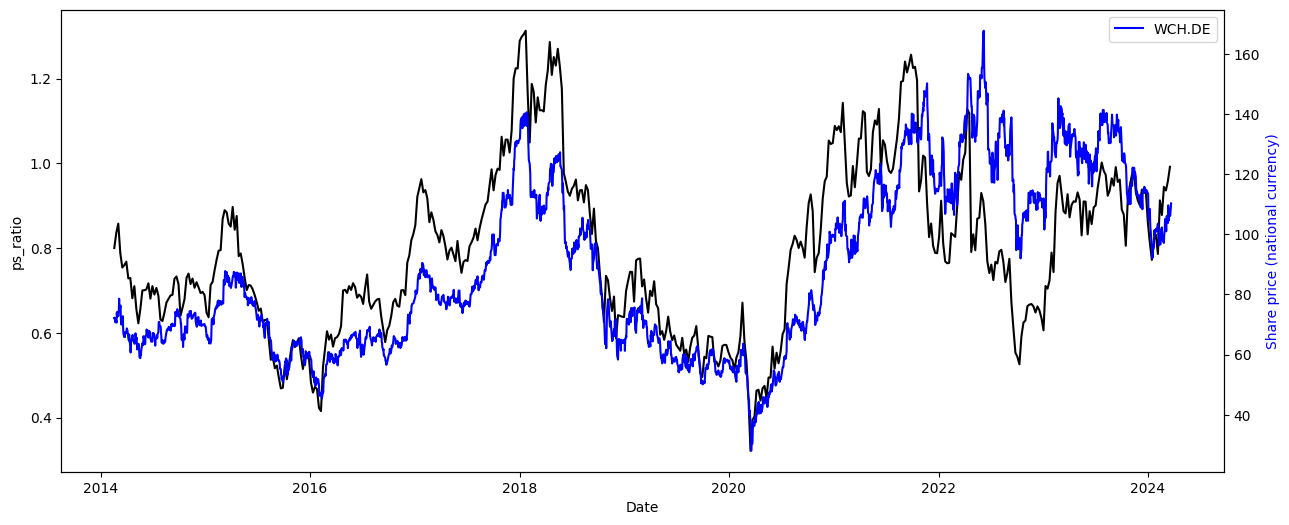

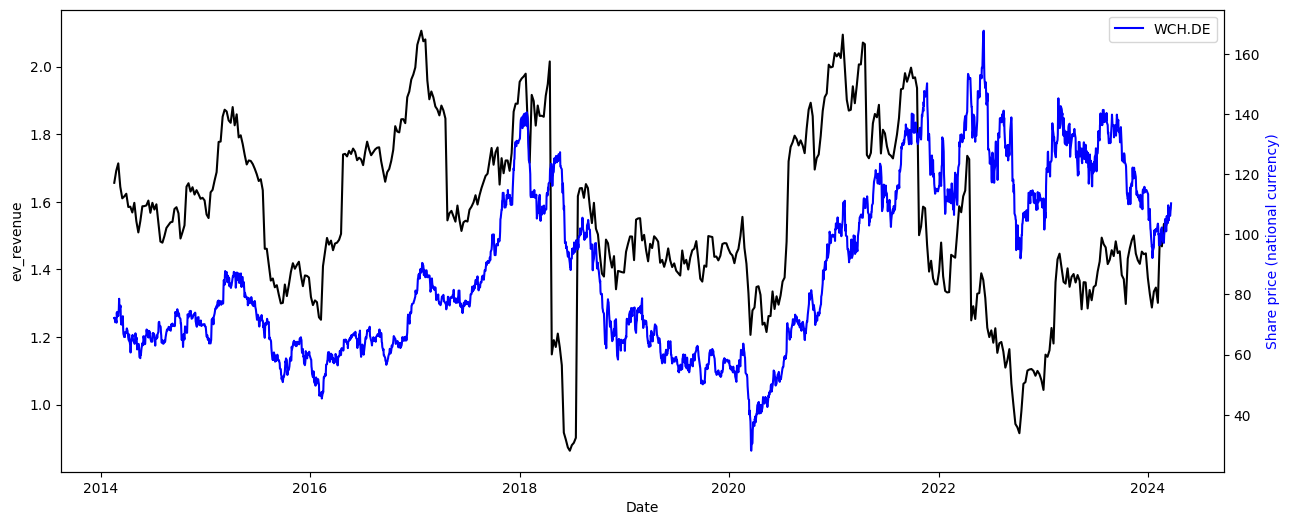

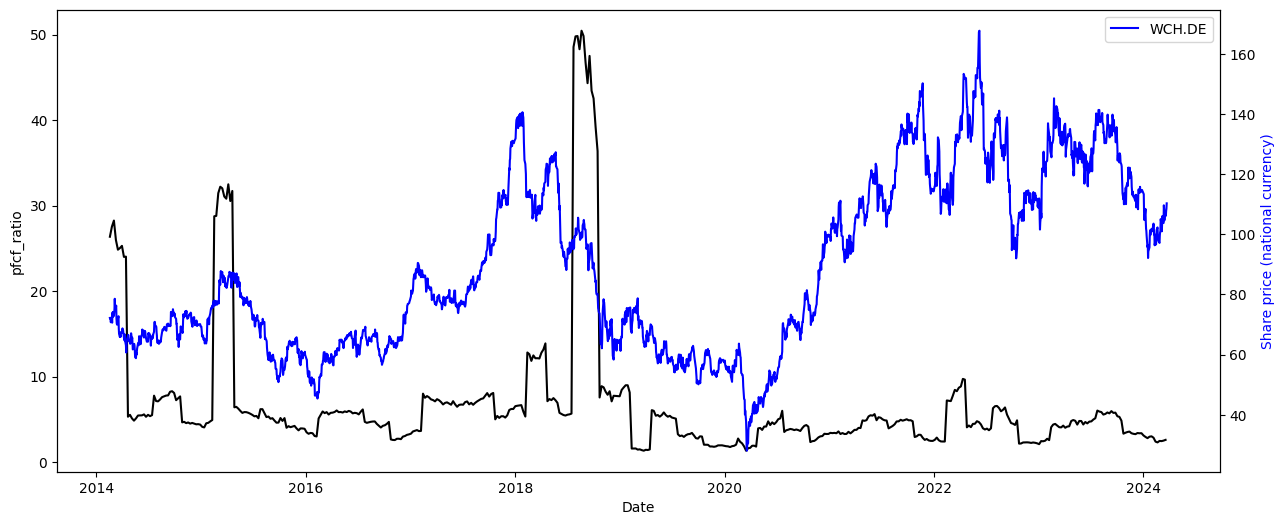

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

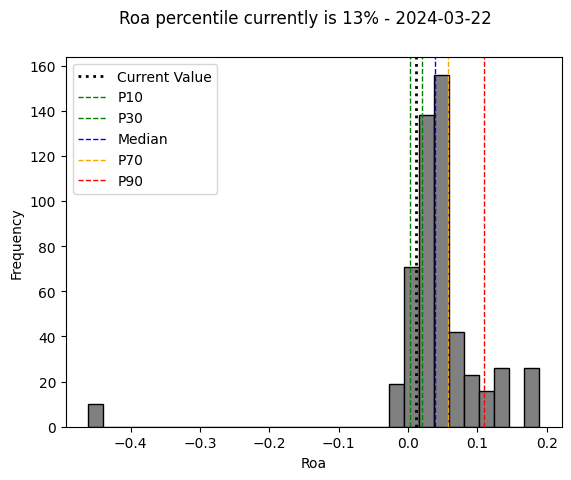

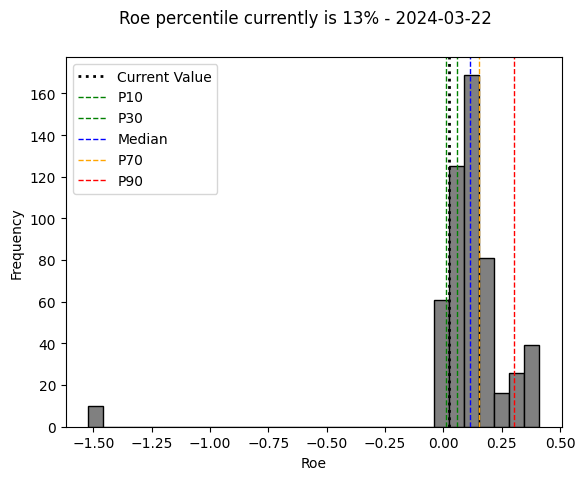

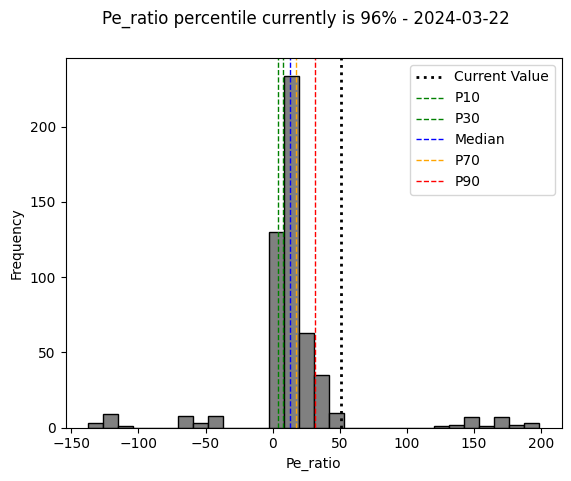

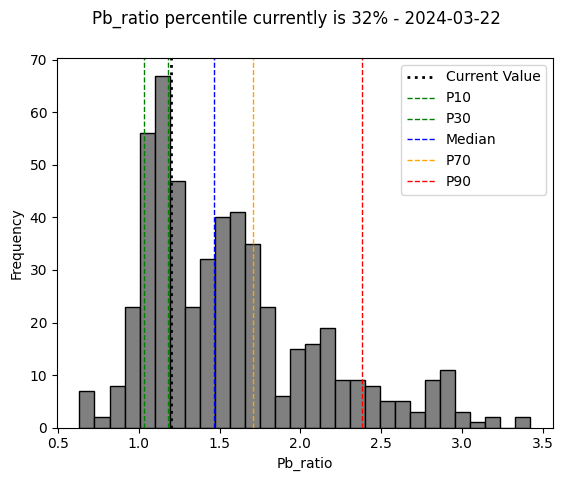

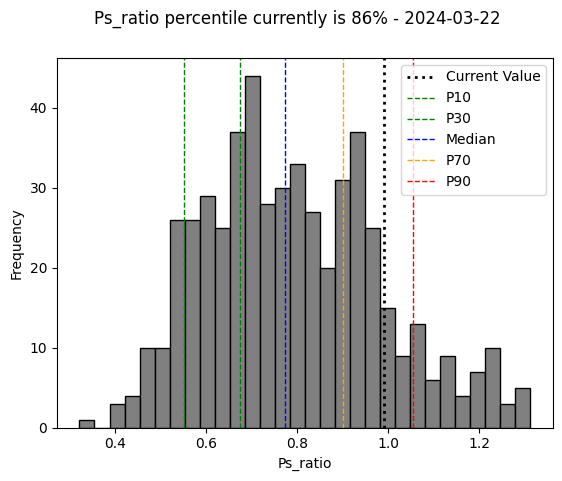

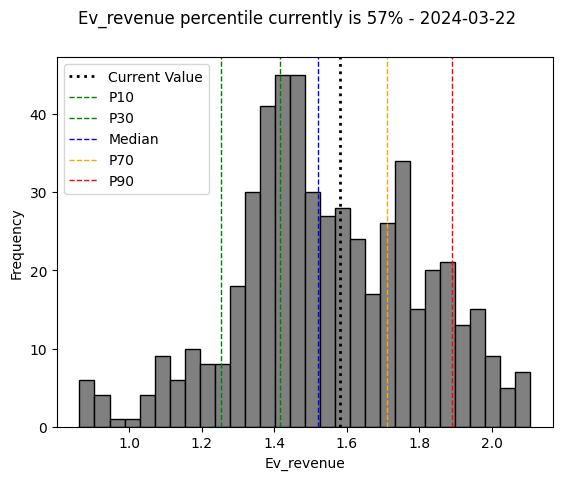

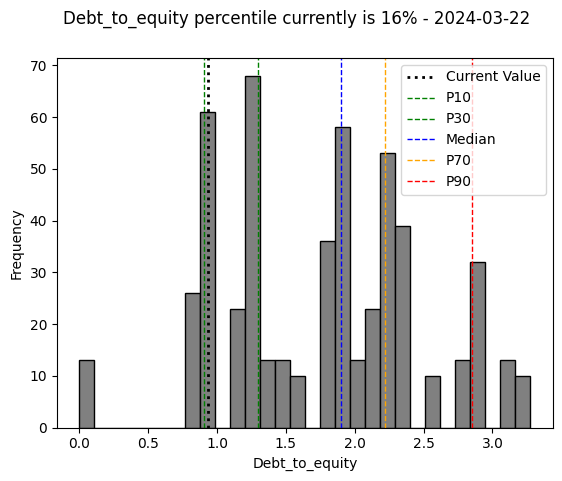

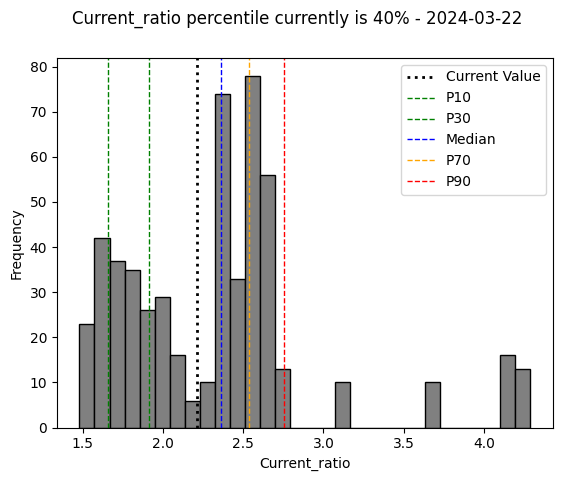

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.977317,-0.018693,0.200340,0.267638,-0.111355,-0.230704,-0.111496
roe,0.977317,1.000000,0.000483,0.277689,0.266680,0.030177,-0.084659,-0.127965
pe_ratio,-0.018693,0.000483,1.000000,0.026580,0.078625,0.136510,0.056682,0.205366
pb_ratio,0.200340,0.277689,0.026580,1.000000,0.598784,0.733904,0.583320,0.242618
ps_ratio,0.267638,0.266680,0.078625,0.598784,1.000000,0.476429,-0.178899,0.200320
ev_revenue,-0.111355,0.030177,0.136510,0.733904,0.476429,1.000000,0.664263,0.049429
debt_to_equity,-0.230704,-0.084659,0.056682,0.583320,-0.178899,0.664263,1.000000,0.022587
current_ratio,-0.111496,-0.127965,0.205366,0.242618,0.200320,0.049429,0.022587,1.000000


6 timestemos have been found!


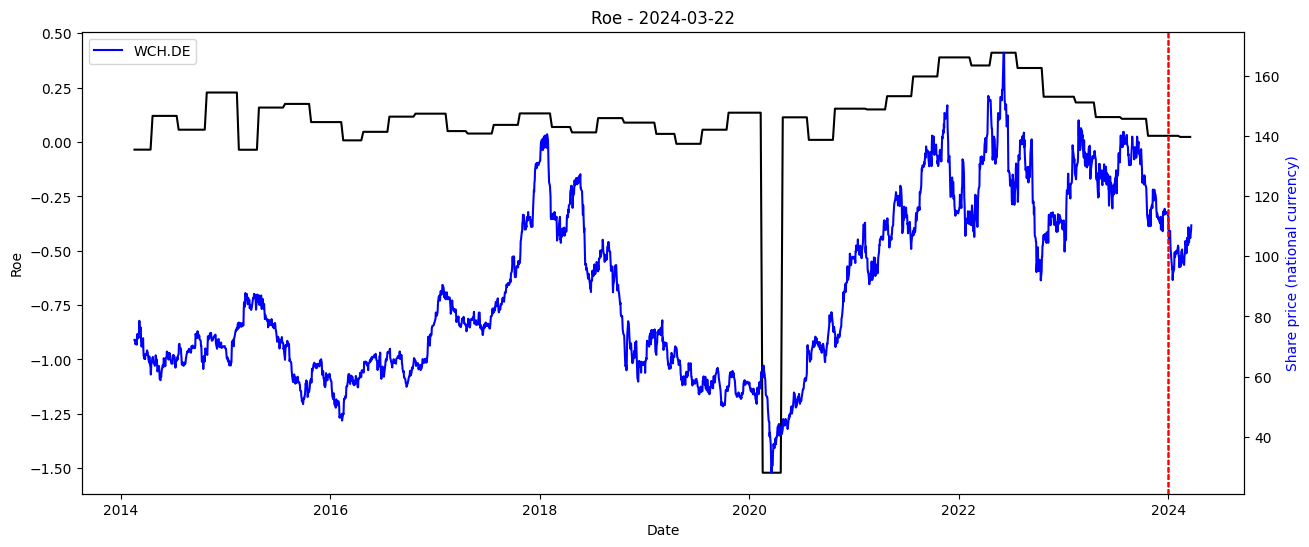

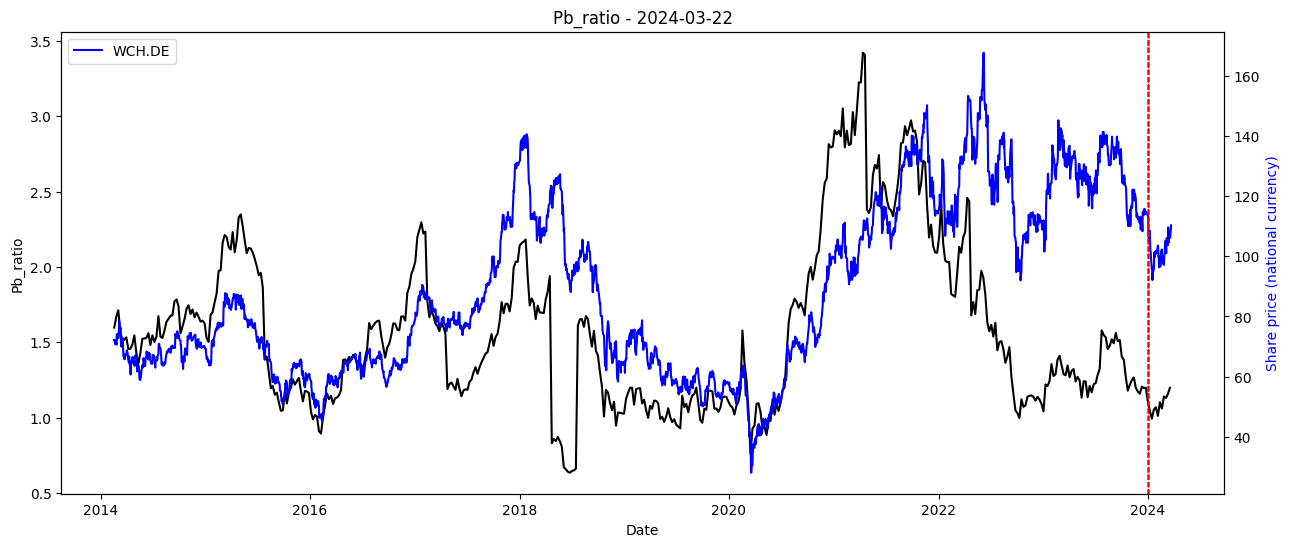

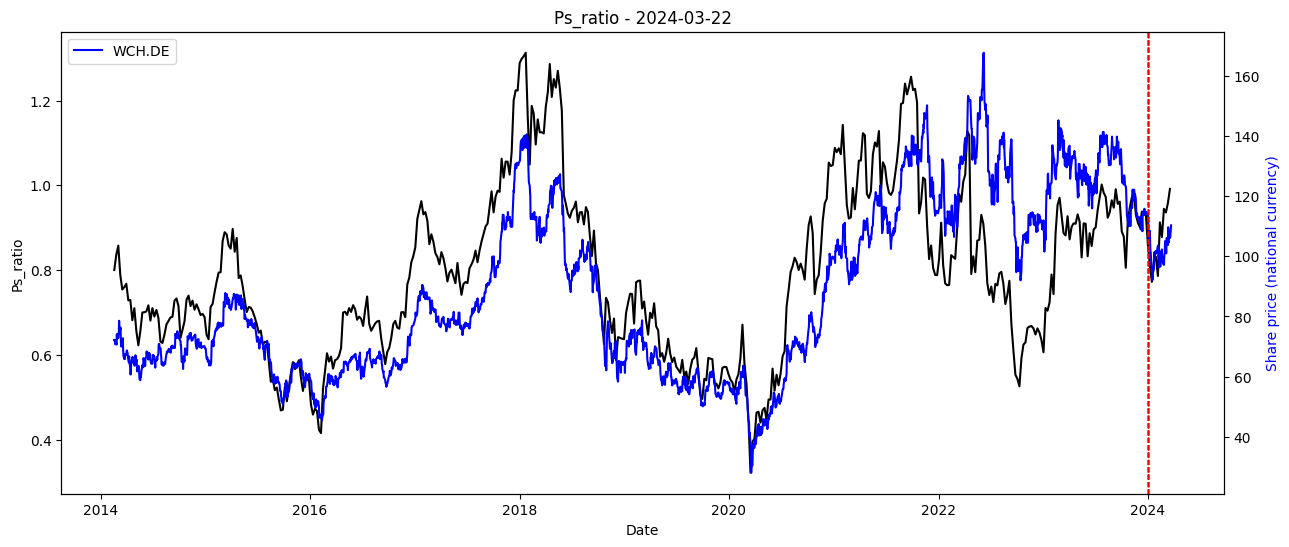

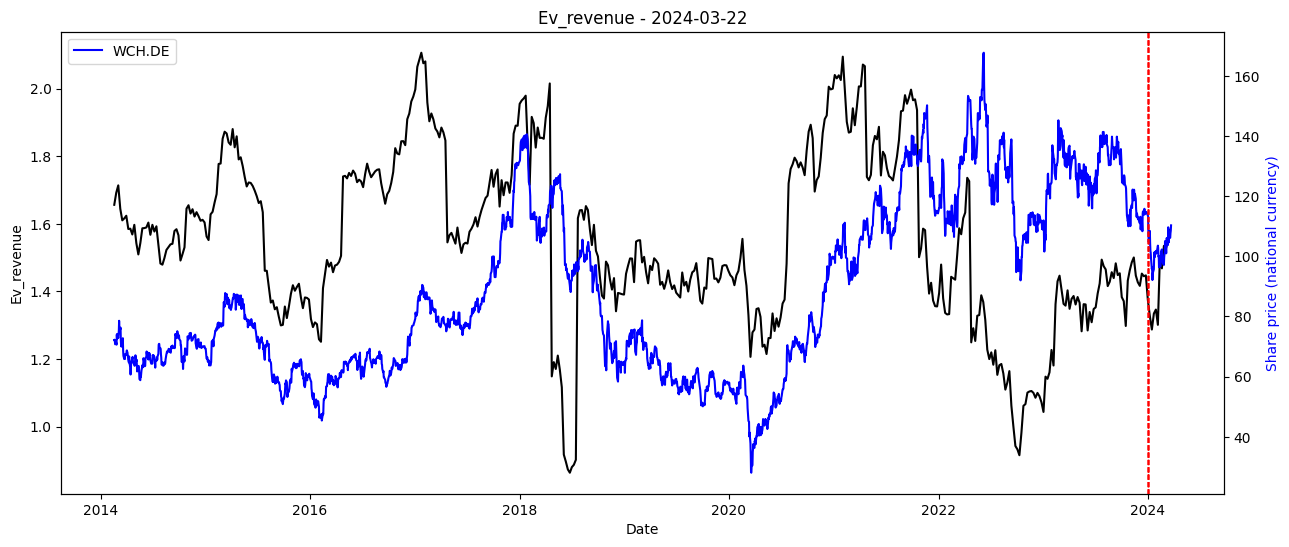

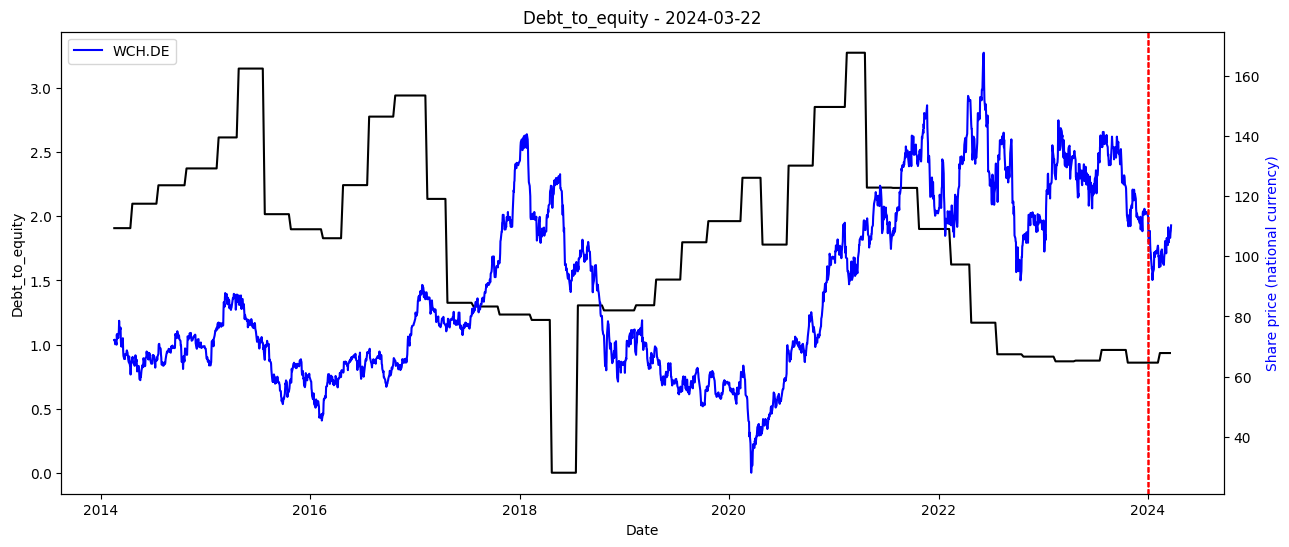

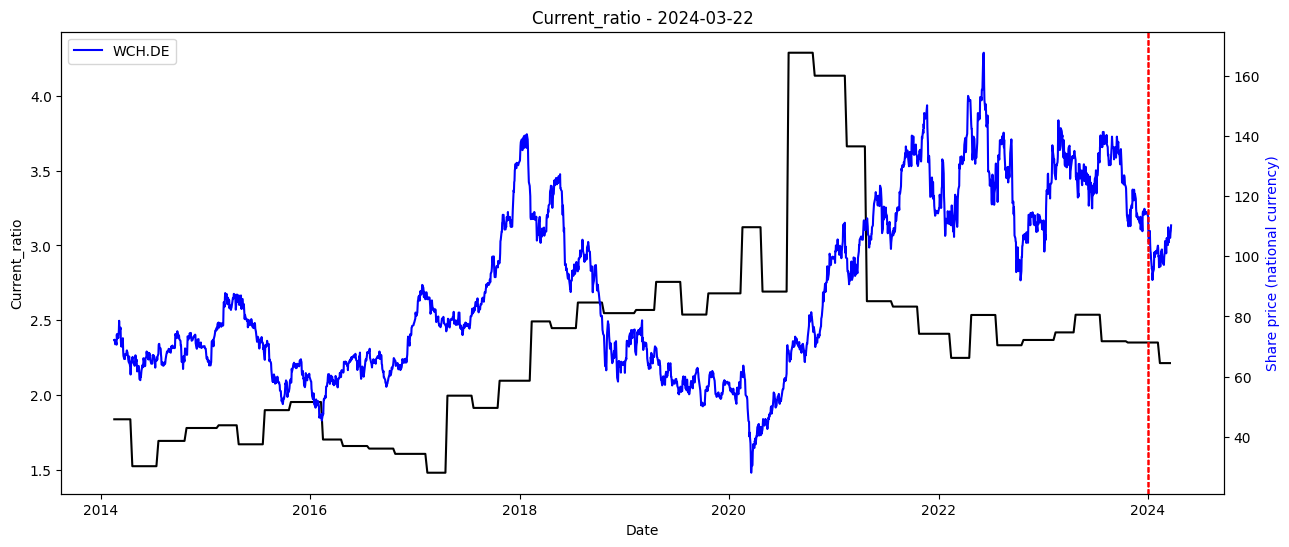

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )